# Royals Modeling Project

## This Jupyter Notebook showcases how I created the models that are used in the Streamlit Web Application. I implimented the XGBoost Classifier algorithm to build decision trees that ultimately predicts whether a situation will be out or safe. 

In [41]:
## Import Libs
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, roc_auc_score, log_loss, average_precision_score, make_scorer, precision_score, f1_score
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
import json

In [42]:
## Read CSV
df = pd.read_csv('dataset_2025.csv')
df

,throw_id,team_id,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,receiver_position,exchange_time,throw_pos_x,...,bounce_velo_y,bounce_velo_z,receiver_pos_x,receiver_pos_y,receiver_dist_from_1b,throw_deflected_by_receiver,start_state,end_state,runs_on_play,batter_result
0,3,11,400,6,400,6,63,3,1.533,-60.116123,...,-25.452504,7.330194,56.199323,60.187776,8.202015,0,____1,1___1,0,first
1,6,11,228,5,390,4,63,3,0.534,-0.562563,...,NaN,NaN,59.013134,65.657938,5.047566,0,1___1,1___2,0,first
2,7,8,415,4,415,4,143,3,1.266,1.598751,...,NaN,NaN,61.037489,64.429134,2.719261,0,123_1,____3,0,out
3,8,8,308,1,308,1,143,3,1.800,25.403185,...,NaN,NaN,63.142075,65.648720,2.069797,0,____1,____2,0,out
4,10,1,314,4,300,6,514,3,0.733,8.957441,...,NaN,NaN,59.770395,64.046058,3.890504,0,123_1,____3,0,out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33189,1,300,6,187,4,63,3,0.567,-0.706883,...,-32.706535,8.013511,61.579339,66.498556,3.523959,0,123_1,1_3_2,1,first
19996,33190,1,768,7,768,7,63,3,1.134,-72.726998,...,-30.850832,11.182392,60.859688,61.483396,3.518128,0,1___0,1___1,0,out
19997,33192,1,63,3,300,6,63,3,1.266,7.741671,...,NaN,NaN,59.986376,65.275522,4.002790,0,1___1,____3,0,out
19998,33193,15,713,4,713,4,313,3,1.200,65.300092,...,NaN,NaN,60.946962,64.565955,2.847538,0,____2,____3,0,out


In [43]:
## Feature Engineering
## First Base constant coordinates
df['first_base_x'] = 63.64
df['first_base_y'] = 63.64

## Distance from batter to first base
df['distance_batter_to_first_base'] = ((df['first_base_x'] - df['batter_pos_x_at_throw']) ** 2 + (df['first_base_y'] - df['batter_pos_y_at_throw']) ** 2) ** 0.5

## Distance from thrower to reciever
df['distance_thrower_to_reciever'] = ((df['receiver_pos_x'] - df['throw_pos_x']) ** 2 + (df['receiver_pos_y'] - df['throw_pos_y']) ** 2) ** 0.5

## Distnace from bounce to receiver
df['distance_bounce_to_reciever'] = ((df['receiver_pos_x'] - df['bounce_pos_x']) ** 2 + (df['receiver_pos_y'] - df['bounce_pos_y']) ** 2) ** 0.5

## Throw Velocity
df['throw_velocity'] = ((df['throw_velo_x']) ** 2 + (df['throw_velo_y']) ** 2 + (df['throw_velo_z']) ** 2) ** 0.5

## Bounce Velocity
df['bounce_velocity'] = ((df['bounce_velo_x']) ** 2 + (df['bounce_velo_y']) ** 2 + (df['bounce_velo_z']) ** 2) ** 0.5

## Batter result binary
df['batter_out'] = 0
df.loc[df['batter_result'] == 'out', 'batter_out'] = 1
df

,throw_id,team_id,fielder_id,fielder_position,thrower_id,thrower_position,receiver_id,receiver_position,exchange_time,throw_pos_x,...,runs_on_play,batter_result,first_base_x,first_base_y,distance_batter_to_first_base,distance_thrower_to_reciever,distance_bounce_to_reciever,throw_velocity,bounce_velocity,batter_out
0,3,11,400,6,400,6,63,3,1.533,-60.116123,...,0,first,63.64,63.64,52.192861,136.796243,20.377200,69.340470,42.170532,0
1,6,11,228,5,390,4,63,3,0.534,-0.562563,...,0,first,63.64,63.64,28.003684,82.565048,NaN,69.011990,NaN,0
2,7,8,415,4,415,4,143,3,1.266,1.598751,...,0,out,63.64,63.64,51.024662,83.473573,NaN,65.430531,NaN,1
3,8,8,308,1,308,1,143,3,1.800,25.403185,...,0,out,63.64,63.64,65.363545,38.170533,NaN,27.407756,NaN,1
4,10,1,314,4,300,6,514,3,0.733,8.957441,...,0,out,63.64,63.64,32.348165,80.254771,NaN,82.106379,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33189,1,300,6,187,4,63,3,0.567,-0.706883,...,1,first,63.64,63.64,26.623502,87.012785,10.213375,72.303155,49.115433,0
19996,33190,1,768,7,768,7,63,3,1.134,-72.726998,...,0,out,63.64,63.64,54.556072,224.530817,19.530884,87.388471,40.226137,1
19997,33192,1,63,3,300,6,63,3,1.266,7.741671,...,0,out,63.64,63.64,31.960994,79.157390,NaN,71.488384,NaN,1
19998,33193,15,713,4,713,4,313,3,1.200,65.300092,...,0,out,63.64,63.64,42.255210,75.906954,NaN,70.465888,NaN,1


## Thrower Eval

In [44]:
thrower_eval_df = df[['exchange_time', 'throw_velocity', 'batter_velo_at_throw', 'distance_batter_to_first_base', 'distance_thrower_to_reciever', 'batter_out']]
## Dropping nulls
thrower_eval_df = thrower_eval_df.dropna()

### Model Creation

In [46]:
X = thrower_eval_df.drop(columns={'batter_out'})
y = thrower_eval_df['batter_out']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

## Saving feature names
with open('thrower_eval_feature_names.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)

In [47]:
## Params model trained on
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

In [48]:
## Best Params after training
#'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0
param_dist = {
    'n_estimators': [300],
    'max_depth': [7],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [1],
    'reg_lambda': [5]
}



## Intializing XGBoost Classifier
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

## Use precision as scoring metric because the goal is to predict the outputs of outs
aucpr_scorer = make_scorer(average_precision_score)

random_search = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_dist,
    n_iter=300,
    scoring=aucpr_scorer,
    cv=5,
    verbose=3,
    random_state=42,
    error_score='raise'
)

random_search.fit(X_train, y_train)

C:\Users\jason\AppData\Roaming\Python\Python314\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=0.951 total time=   0.1s
[CV 2/5] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=0.956 total time=   0.1s
[CV 3/5] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=0.959 total time=   0.1s
[CV 4/5] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=0.947 total time=   0.1s
[CV 5/5] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=0.952 total time=   0.1s


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [1.0], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [7], ...}"
,n_iter,300
,scoring,make_scorer(a...hod='predict')
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Precision Score: 0.9873
Accuracy: 0.8441


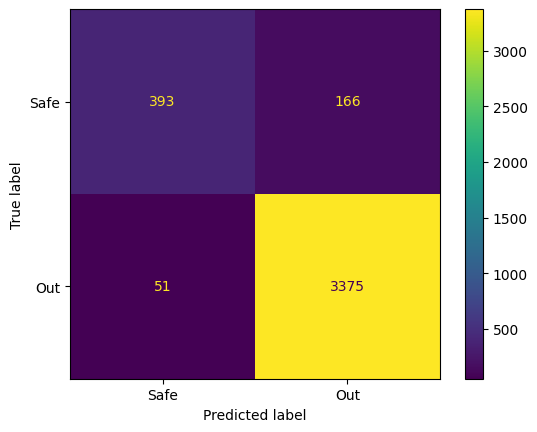

In [49]:
## Version 2
## Displaying the best model parameters
best_model_v2 = random_search.best_estimator_
best_model_params_v2 = random_search.best_params_
print(best_model_params_v2)
## Probability
y_proba_v2 = best_model_v2.predict_proba(X_test)[:,1]
## Predict
y_pred_v2 = best_model_v2.predict(X_test)
print(f'Precision Score: {round(average_precision_score(y_test, y_proba_v2), 4)}')
print(f'Accuracy: {round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_v2), 4)}')
#print(f'Log Loss: {round(log_loss(y_test, y_proba), 4)}')
#print(f'ROC AUC Score: {round(roc_auc_score(y_test, y_proba), 4)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_v2, display_labels=['Safe', 'Out'], values_format='d')
best_model_v2.save_model('thrower_model_v2.ubj')

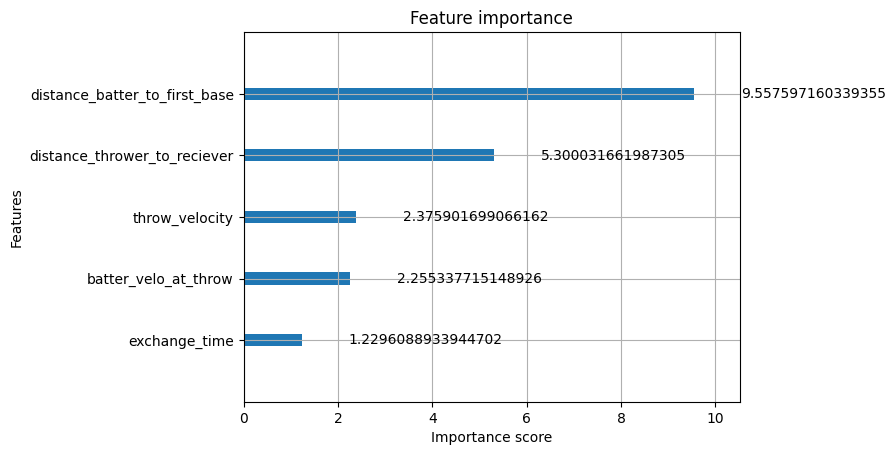

In [50]:
## Metric Importance
xgb.plot_importance(best_model_v2, importance_type='gain', max_num_features=10)
plt.show()

### Predict

#### To predict, we can get the average of the selected variables for the thrower id and see when it will result in an out or not

In [51]:
## Controlables
## Getting averages of controllables
thrower_avg = df[['thrower_id', 'exchange_time', 'throw_velocity']].groupby(['thrower_id']).mean().reset_index()
thrower_avg

,thrower_id,exchange_time,throw_velocity
0,1,1.708684,41.901238
1,2,1.020875,46.979935
2,3,0.700500,77.419755
3,4,0.716500,30.484282
4,5,1.050000,46.515444
...,...,...,...
736,841,1.000000,73.304556
737,842,1.358250,77.116520
738,843,1.122333,55.137300
739,846,1.300000,76.071868


In [52]:
## Ranks
thrower_avg['exchange_time_rank'] = thrower_avg['exchange_time'].rank()
thrower_avg['throw_velocity_rank'] = thrower_avg['throw_velocity'].rank()

In [53]:
## Uncontrollables
## These are the selected by the user on the streamlit (these are all random here in this notebook)
batter_velo_at_throw = 20
receiver_dist_from_1b = 30
distance_batter_to_first_base = 37
distance_thrower_to_reciever = 50

In [54]:
## Adding uncontrollables
thrower_avg['batter_velo_at_throw'] = batter_velo_at_throw
thrower_avg['receiver_dist_from_1b'] = receiver_dist_from_1b
thrower_avg['distance_batter_to_first_base'] = distance_batter_to_first_base
thrower_avg['distance_thrower_to_reciever'] = distance_thrower_to_reciever
thrower_avg

,thrower_id,exchange_time,throw_velocity,exchange_time_rank,throw_velocity_rank,batter_velo_at_throw,receiver_dist_from_1b,distance_batter_to_first_base,distance_thrower_to_reciever
0,1,1.708684,41.901238,652.0,114.0,20,30,37,50
1,2,1.020875,46.979935,167.0,173.0,20,30,37,50
2,3,0.700500,77.419755,47.0,656.0,20,30,37,50
3,4,0.716500,30.484282,50.0,16.0,20,30,37,50
4,5,1.050000,46.515444,196.5,164.0,20,30,37,50
...,...,...,...,...,...,...,...,...,...
736,841,1.000000,73.304556,149.5,563.0,20,30,37,50
737,842,1.358250,77.116520,505.0,647.0,20,30,37,50
738,843,1.122333,55.137300,288.5,279.0,20,30,37,50
739,846,1.300000,76.071868,463.0,619.0,20,30,37,50


In [55]:
## Loading Model
model = xgb.XGBClassifier()
model.load_model('thrower_model_v2.ubj')
## Leading feature names
with open('thrower_eval_feature_names.json', 'r') as f:
    feature_names = json.load(f)
out_probabilities = model.predict_proba(thrower_avg[feature_names])[:, 1].tolist()
out_predictions = model.predict(thrower_avg[feature_names]).tolist()

In [56]:
out = pd.DataFrame({'probabilities': out_probabilities, 'predictions': out_predictions})
thrower_final_out_display = thrower_avg.join(out)
thrower_final_out_display = thrower_final_out_display[['thrower_id', 'probabilities', 'predictions']]
thrower_final_out_display.loc[thrower_final_out_display['predictions'] == 1, 'predictions'] = 'Out'
thrower_final_out_display.loc[thrower_final_out_display['predictions'] == 0, 'predictions'] = 'Safe'
thrower_final_out_display

C:\Users\jason\AppData\Local\Temp\ipykernel_19276\599474859.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Out' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  thrower_final_out_display.loc[thrower_final_out_display['predictions'] == 1, 'predictions'] = 'Out'


,thrower_id,probabilities,predictions
0,1,0.997684,Out
1,2,0.998334,Out
2,3,0.990916,Out
3,4,0.994483,Out
4,5,0.998035,Out
...,...,...,...
736,841,0.996133,Out
737,842,0.996163,Out
738,843,0.998698,Out
739,846,0.994033,Out


## Receiver Eval

In [57]:
## How well can they catch errant throws
receiver_eval_df = df[['receiver_dist_from_1b', 'distance_batter_to_first_base', 'distance_thrower_to_reciever', 'distance_bounce_to_reciever', 'batter_velo_at_throw', 'bounce_velocity', 'batter_out']]
## Dropping nulls
receiver_eval_df = receiver_eval_df.dropna()

### Model Creation

In [59]:
X = receiver_eval_df.drop(columns={'batter_out'})
y = receiver_eval_df['batter_out']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

## Saving feature names
with open('receiver_eval_feature_names.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)

In [60]:
## Params model trained on
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [5, 10]
}

In [61]:
## Best Params after training 
#'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8
param_dist = {
    'n_estimators': [200],
    'max_depth': [5],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'colsample_bylevel': [0.8],
    'gamma': [0.3],
    'reg_alpha': [0.01],
    'reg_lambda': [10]
}
## Intializing XGBoost Classifier
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

## Use precision as scoring metric because the goal is to predict the outputs of outs
aucpr_scorer = make_scorer(average_precision_score)

random_search = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_dist,
    n_iter=300,
    scoring=aucpr_scorer,
    cv=5,
    verbose=3,
    random_state=42,
    error_score='raise'
)

random_search.fit(X_train, y_train)

C:\Users\jason\AppData\Roaming\Python\Python314\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bylevel=0.8, colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=10, subsample=0.8;, score=0.669 total time=   0.0s
[CV 2/5] END colsample_bylevel=0.8, colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=10, subsample=0.8;, score=0.713 total time=   0.0s
[CV 3/5] END colsample_bylevel=0.8, colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=10, subsample=0.8;, score=0.718 total time=   0.0s
[CV 4/5] END colsample_bylevel=0.8, colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=10, subsample=0.8;, score=0.732 total time=   0.0s
[CV 5/5] END colsample_bylevel=0.8, colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.01, reg_lambda=10

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bylevel': [0.8], 'colsample_bytree': [1.0], 'gamma': [0.3], 'learning_rate': [0.05], ...}"
,n_iter,300
,scoring,make_scorer(a...hod='predict')
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


{'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
Precision Score: 0.8987
Accuracy: 0.8626


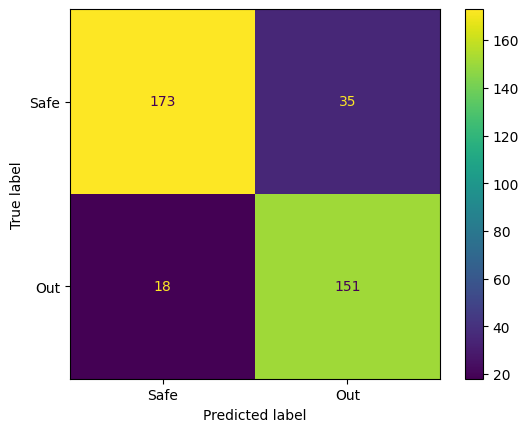

In [62]:
## Version 6
## Displaying the best model parameters
best_model_v6 = random_search.best_estimator_
best_model_params_v6 = random_search.best_params_
print(best_model_params_v6)
## Probability
y_proba_v6 = best_model_v6.predict_proba(X_test)[:,1]
## Predict
y_pred_v6 = best_model_v6.predict(X_test)
print(f'Precision Score: {round(average_precision_score(y_test, y_proba_v6), 4)}')
print(f'Accuracy: {round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_v6), 4)}')
#print(f'Log Loss: {round(log_loss(y_test, y_proba), 4)}')
#print(f'ROC AUC Score: {round(roc_auc_score(y_test, y_proba), 4)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_v6, display_labels=['Safe', 'Out'], values_format='d')
best_model_v6.save_model('receiver_model_v6.ubj')

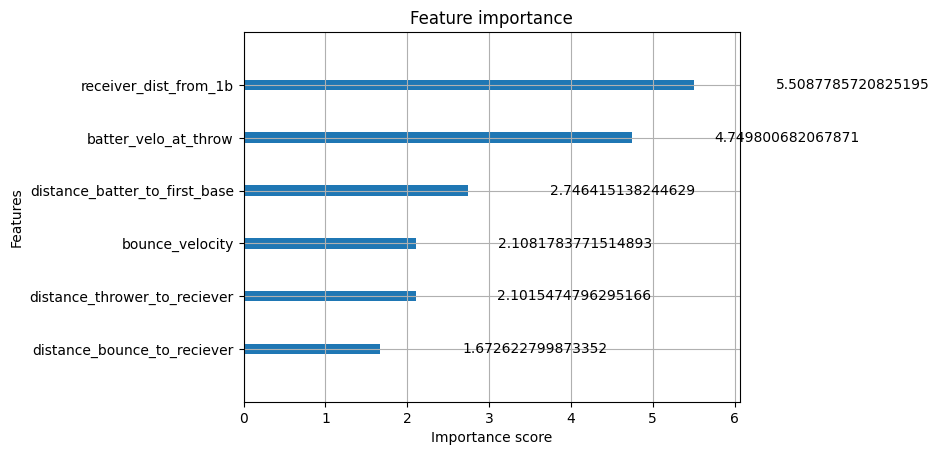

In [63]:
## Metric Importance
xgb.plot_importance(best_model_v6, importance_type='gain', max_num_features=10)
plt.show()

### Predict

#### Like the thrower predictions, we can get the average of the selected variables for the receiver id and see when it will result in an out or not

In [64]:
## Controlables
## Getting averages of controllables
receiver_avg = df[['receiver_id', 'receiver_dist_from_1b']].groupby(['receiver_id']).mean().reset_index()
receiver_avg

,receiver_id,receiver_dist_from_1b
0,13,6.299552
1,14,7.166237
2,17,6.859221
3,18,5.312795
4,21,4.424614
...,...,...
127,859,5.838309
128,860,3.354271
129,861,3.631617
130,862,5.536459


In [65]:
## Uncontrollables
## These are the selected by the user on the streamlit (these are all random here in this notebook)
batter_velo_at_throw = 26
distance_bounce_to_reciever = 30
distance_batter_to_first_base = 37
distance_thrower_to_reciever = 50
bounce_velocity = 25

In [66]:
## Adding uncontrollables
receiver_avg['batter_velo_at_throw'] = batter_velo_at_throw
receiver_avg['distance_bounce_to_reciever'] = distance_bounce_to_reciever
receiver_avg['distance_batter_to_first_base'] = distance_batter_to_first_base
receiver_avg['distance_thrower_to_reciever'] = distance_thrower_to_reciever
receiver_avg['bounce_velocity'] = bounce_velocity
receiver_avg

,receiver_id,receiver_dist_from_1b,batter_velo_at_throw,distance_bounce_to_reciever,distance_batter_to_first_base,distance_thrower_to_reciever,bounce_velocity
0,13,6.299552,26,30,37,50,25
1,14,7.166237,26,30,37,50,25
2,17,6.859221,26,30,37,50,25
3,18,5.312795,26,30,37,50,25
4,21,4.424614,26,30,37,50,25
...,...,...,...,...,...,...,...
127,859,5.838309,26,30,37,50,25
128,860,3.354271,26,30,37,50,25
129,861,3.631617,26,30,37,50,25
130,862,5.536459,26,30,37,50,25


In [69]:
## Loading Model
model = xgb.XGBClassifier()
model.load_model('receiver_model_v6.ubj')
## Leading feature names
with open('receiver_eval_feature_names.json', 'r') as f:
    feature_names = json.load(f)
out_probabilities = model.predict_proba(receiver_avg[feature_names])[:, 1].tolist()
out_predictions = model.predict(receiver_avg[feature_names]).tolist()

In [71]:
out = pd.DataFrame({'probabilities': out_probabilities, 'predictions': out_predictions})
receiver_final_out_display = receiver_avg.join(out)
receiver_final_out_display = receiver_final_out_display[['receiver_id', 'probabilities', 'predictions']]
receiver_final_out_display.loc[receiver_final_out_display['predictions'] == 1, 'predictions'] = 'Out'
receiver_final_out_display.loc[receiver_final_out_display['predictions'] == 0, 'predictions'] = 'Safe'
receiver_final_out_display

C:\Users\jason\AppData\Local\Temp\ipykernel_19276\2938870511.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Out' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  receiver_final_out_display.loc[receiver_final_out_display['predictions'] == 1, 'predictions'] = 'Out'


,receiver_id,probabilities,predictions
0,13,0.098513,Safe
1,14,0.072145,Safe
2,17,0.072145,Safe
3,18,0.119587,Safe
4,21,0.255002,Safe
...,...,...,...
127,859,0.112230,Safe
128,860,0.681535,Out
129,861,0.553834,Out
130,862,0.119587,Safe
